In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many chars do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3 # context length: how many chars do we take to predict the next one?
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [7]:
C = torch.randn((27, 2))

In [8]:
C[15]

tensor([-0.2372, -0.7871])

In [9]:
F.one_hot(torch.tensor(15), num_classes=27).float() @ C

tensor([-0.2372, -0.7871])

In [10]:
C[X].shape

torch.Size([228146, 3, 2])

In [11]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [12]:
W1 = torch.randn([6, 100])
b1 = torch.randn(100)

In [13]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [14]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [15]:
emb.shape

torch.Size([228146, 3, 2])

In [17]:
emb.view(-1,6).shape

torch.Size([228146, 6])

In [18]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [19]:
h.shape

torch.Size([228146, 100])

In [20]:
W2 = torch.randn(size=(100,27))
b2 = torch.randn(27)

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

torch.Size([228146, 27])

In [23]:
counts = logits.exp()

In [24]:
prob = counts / counts.sum(1, keepdim=True)

In [25]:
prob[0].sum()

tensor(1.0000)

In [31]:
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()

In [32]:
loss

tensor(17.5690)

In [33]:
###  ----------- done better :] ------- ###

In [9]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182437, 3]), torch.Size([182437]))

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(size=(27, 2), generator=g)
W1 = torch.randn(size=(6,500), generator=g)
b1 = torch.randn(500, generator=g)
W2 = torch.randn(size=(500, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [24]:
sum(p.nelement() for p in parameters) # no. of total params

17081

In [ ]:
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2   #(32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(Xtr.shape[0]), Ytr].log().mean()
loss

tensor(19.5052)

In [39]:
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052)

In [25]:
for p in parameters:
    p.requires_grad = True

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [34]:
lri = []
lossi = []
for i in range(30000):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2   #(32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad 

    # track stats
    # lri.append(lr)
    # lossi.append(loss.item())
    
print(loss.item())

2.553245782852173


In [35]:
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2   #(32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.390864372253418

In [36]:
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2   #(32, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.3558385372161865

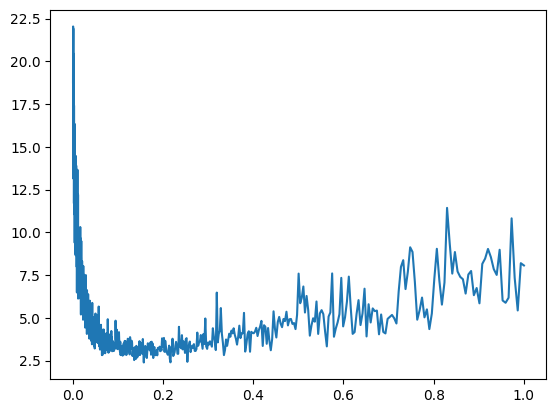

In [77]:
plt.plot(lri, lossi)

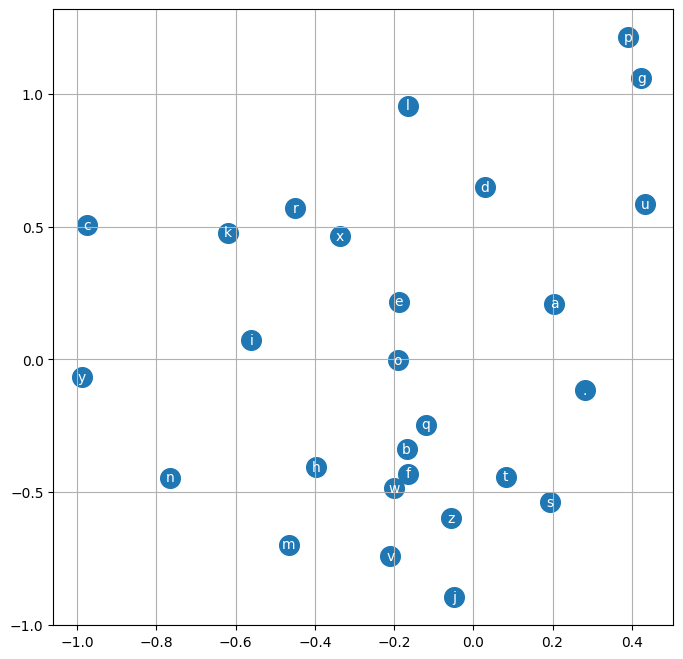

In [37]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [40]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * 3 # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mouraymyah.
seer.
mahryah.
zetsastendrari.
azeredeelin.
shy.
jelle.
eliestanarleigh.
malarain.
shub.
rumairiest.
jahettelinneteudrius.
macder.
yurlemele.
kayshayah.
amahil.
salynn.
unazelelee.
ren.
cut.
